In [5]:
import numpy as np
import swarms
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from random import randint, seed, uniform

from swarms import LSUN, MSUN, TSUN, PC, AU, MEARTH, REARTH, RJUP, MJUP, JY, YEAR, MICRON

try:
    plt.style.use('paper')
except:
    pass

In [2]:
def get_masses(Nvals, Mmin=15, Mmax=13*318): # defaults are 15 Earth masses (Neptune) to 13*318 (13 Mjup)
    Ninterp = 100
    alpha = -0.86

    ms = np.linspace(Mmin, Mmax, Ninterp)
    pdf = ms**(alpha-1) # dN/dlogM = dN/dM * m, so dN/dM \propto m^(alpha-1)
    cumpdf = np.cumsum(pdf)/pdf.sum()
    randv = np.random.uniform(size=Nvals)
    idxs = np.searchsorted(cumpdf, randv)
    masses = ms[[idx for idx in idxs if idx < len(cumpdf)]]
    return masses

In [3]:
GPI = pd.read_csv("../csvs/fullGPIsample.csv", index_col=0)
GPI = GPI[~GPI['Distance_distance'].isnull()]
GPI = GPI.reset_index(drop=True)
GPI['Age'] = 0
GPI.tail()

,S_Type,Distance_distance,FLUX_I,FLUX_H,Fe_H_Teff,Class,subtype,Mbol,Lum,Teff,Mass,Age
594,B9V,48.5835,NaN,4.622,10860,B,9,0.570,46.558609,10850.0,2.455,0
595,A7III/IV,67.1100,NaN,5.879,7834,A,7,2.445,8.279422,8000.0,1.595,0
596,F6V,35.3895,6.370,5.787,6255,F,6,3.860,2.249055,6400.0,1.160,0
597,K2V,21.9270,7.194,6.007,0,K,2,5.620,0.444631,4930.0,0.738,0
598,A1V,47.0754,NaN,4.949,9057,A,1,1.440,20.892961,9370.0,2.005,0


In [4]:
seed(0)

def loguniform(minval, maxval):
    return 10**uniform(np.log10(minval), np.log10(maxval))

def draw_star(GPI):
    if isinstance(GPI, pd.Series):
        star = GPI
    else:
        idx = randint(0, GPI.shape[0]-1)
        star = GPI.loc[idx]
        
    return swarms.Star(M=star['Mass']*MSUN, L=star['Lum']*LSUN, T=star['Fe_H_Teff'], d=star['Distance_distance']*PC)

In [11]:
%%time

lamb = 1.65*MICRON
g = 0.32
Nvals = 1500

masses = get_masses(Nvals)
CRthermals, CRscats, CRs = np.zeros(Nvals), np.zeros(Nvals), np.zeros(Nvals)
for i, m in enumerate(masses):
    star = draw_star(GPI)
    amin = 10#0.2*star.d/pc
    amax = 200#1.2*star.d/pc
    a = loguniform(amin, amax)
    if m < 20:
        m = 21
    if m > 3180:
        m = 3100
    print(m)
    planet = swarms.Planet(star, M=m*MEARTH, a=a*AU, Q=0.5, R=None, Z='002', age=1.5e7*YEAR)
    CRthermals[i] = planet.computeCRthermal(lamb)
    if np.isnan(CRthermals[i]):
        CRthermals[i] = 0
    CRscats[i] = planet.computeCRscat(g)
    CRs[i] = CRthermals[i] + CRscats[i]

21
21
21
21
21
21
21
21
21
98.21212121212122
597.4848484848485
21
21
21
21
56.60606060606061
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
56.60606060606061
21
21
21
21
21
56.60606060606061
21
21
21
306.24242424242425
56.60606060606061
21
21
21
21
56.60606060606061
21
21
21
21
21
21
21
1263.1818181818182
21
21
21
21
21
21
21
21
56.60606060606061
21
139.8181818181818
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
56.60606060606061
21
21
21
21
21
21
21
21
21
21
21
21
21
21
56.60606060606061
21
21
21
21
56.60606060606061
21
21
21
21
21
21
21
21
21
21
21
56.60606060606061
21
21
21
21
21
21
56.60606060606061
21
21
21
21
21
21
56.60606060606061
21
21
21
21
21
21
21
21
21
1845.6666666666667
21
56.60606060606061
21
21
21
98.21212121212122
21
21
56.60606060606061
264.6363636363636
21
21
21
21
2386.5454545454545
264.6363636363636
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
56.60606060606061
21
21
21
21
98.21212121212122
56.606060606

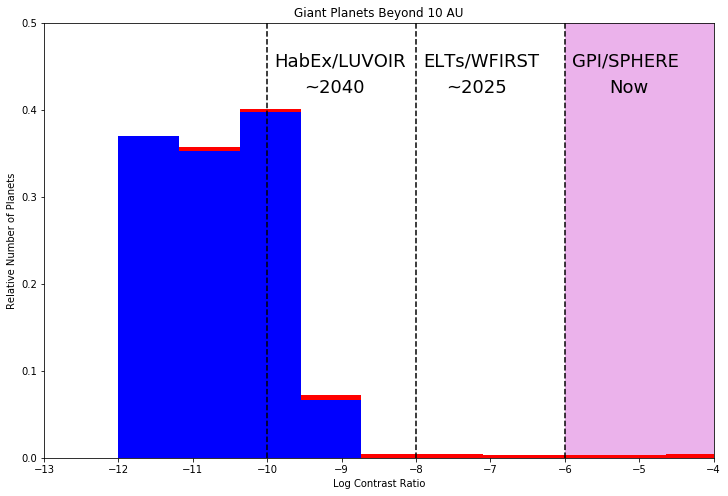

In [12]:
scatdom = CRs[CRscats > CRthermals]
thermaldom = CRs[CRthermals > CRscats]

fig, ax = plt.subplots(figsize=(12,8))
hist, edges, patches = ax.hist([np.log10(scatdom), np.log10(thermaldom)], normed=True, stacked=True, color=['blue', 'red'])
ax.fill_betweenx([0, 0.5], -6, -4, facecolor='m', alpha=0.3)
ax.set_ylim([0, 0.5])
ax.set_xlim([-13, -4])
ax.set_xlabel('Log Contrast Ratio')
ax.set_ylabel('Relative Number of Planets')
ax.axvline(-6, color='k', linestyle='--')
ax.axvline(-8, color='k', linestyle='--')
ax.axvline(-10, color='k', linestyle='--')

ax.text(-9.9, 0.45, "HabEx/LUVOIR", color='k', fontsize=18)
ax.text(-7.9, 0.45, "ELTs/WFIRST", color='k', fontsize=18)
ax.text(-5.9, 0.45, "GPI/SPHERE", color='k', fontsize=18)
ax.text(-9.5, 0.42, "~2040", color='k', fontsize=18)
ax.text(-7.6, 0.42, "~2025", color='k', fontsize=18)
ax.text(-5.4, 0.42, "Now", color='k', fontsize=18)
ax.set_title('Giant Planets Beyond 10 AU')

fig.savefig('fig1.pdf', bbox_inches='tight')

In [13]:
masses[(CRthermals > CRscats) & (np.log10(CRs) > -8)].min()

306.24242424242425

In [14]:
181/318

0.5691823899371069